In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflowjs as tfjs
import json
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
!unzip samples.pkl.zip -d data

Archive:  samples.pkl.zip
  inflating: data/samples.pkl        


In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load .pkl file
with open("data/samples.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))

<class 'tuple'>
2


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
x, y = pkl.load(open('data/samples.pkl', 'rb'))
print(f"Data shape: {x.shape}, Labels shape: {y.shape}")

# Analyze target distributions
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]
print("\nTarget Statistics:")
print(f"Roll:  min={roll.min():.2f}, max={roll.max():.2f}, mean={roll.mean():.2f}, std={roll.std():.2f}")
print(f"Pitch: min={pitch.min():.2f}, max={pitch.max():.2f}, mean={pitch.mean():.2f}, std={pitch.std():.2f}")
print(f"Yaw:   min={yaw.min():.2f}, max={yaw.max():.2f}, mean={yaw.mean():.2f}, std={yaw.std():.2f}")

# Split data with stratification consideration
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=42
)

print(f"\nDataset splits:")
print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

# Standardize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Improved Model Architecture
def create_model(input_dim, learning_rate=0.001):
    """
    Improved architecture with:
    - Deeper network with residual-like connections
    - Batch normalization for training stability
    - Dropout for regularization
    - Gradual dimension reduction
    """
    inputs = Input(shape=(input_dim,))

    # First block
    x = Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second block
    x = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Third block
    x = Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Fourth block
    x = Dense(32, activation='relu',
              kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Dense(3, activation='linear', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile with custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

# Hyperparameters
BATCH_SIZE = 32  # Smaller batch size for better generalization
EPOCHS = 200
LEARNING_RATE = 0.001

# Create model
model = create_model(x_train.shape[1], LEARNING_RATE)
print(model.summary())

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

Data shape: (6288, 2278), Labels shape: (6288, 3)

Target Statistics:
Roll:  min=-46.06, max=43.01, mean=-0.53, std=5.18
Pitch: min=-29.89, max=34.10, mean=2.58, std=7.96
Yaw:   min=-75.55, max=86.85, mean=-0.12, std=13.09

Dataset splits:
Train: (4275, 2278), Val: (755, 2278), Test: (1258, 2278)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2278)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       583,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,675 (2.40 MB)

 Trainable params: 627,715 (2.39 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [ ]:
# Train model
print("\nTraining model...")
hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save('models/model.keras')


Training model...
Epoch 1/200
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 78.2532 - mae: 5.3400
Epoch 1: val_loss improved from inf to 48.84283, saving model to models/best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 78.1197 - mae: 5.3362 - val_loss: 48.8428 - val_mae: 4.7205 - learning_rate: 0.0010
Epoch 2/200
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51.8763 - mae: 4.4994
Epoch 2: val_loss improved from 48.84283 to 36.28544, saving model to models/best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 51.8720 - mae: 4.4985 - val_loss: 36.2854 - val_mae: 3.9324 - learning_rate: 0.0010
Epoch 3/200
130/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 46.4230 - mae: 4.2587
Epoch 3: val_loss did not improve from 36.28544
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 46.4428 - mae: 4.2576 - val_loss: 36.3964 - val_mae: 3.6866 - learning_rate: 0.0010
Epoch 4/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 50.5725 - mae: 4.2792
Epoch 4: val


Model Evaluation:
Train - Loss: 28.9972, MAE: 3.0461°
Val   - Loss: 26.4087, MAE: 3.0672°
Test  - Loss: 37.8192, MAE: 3.2359°


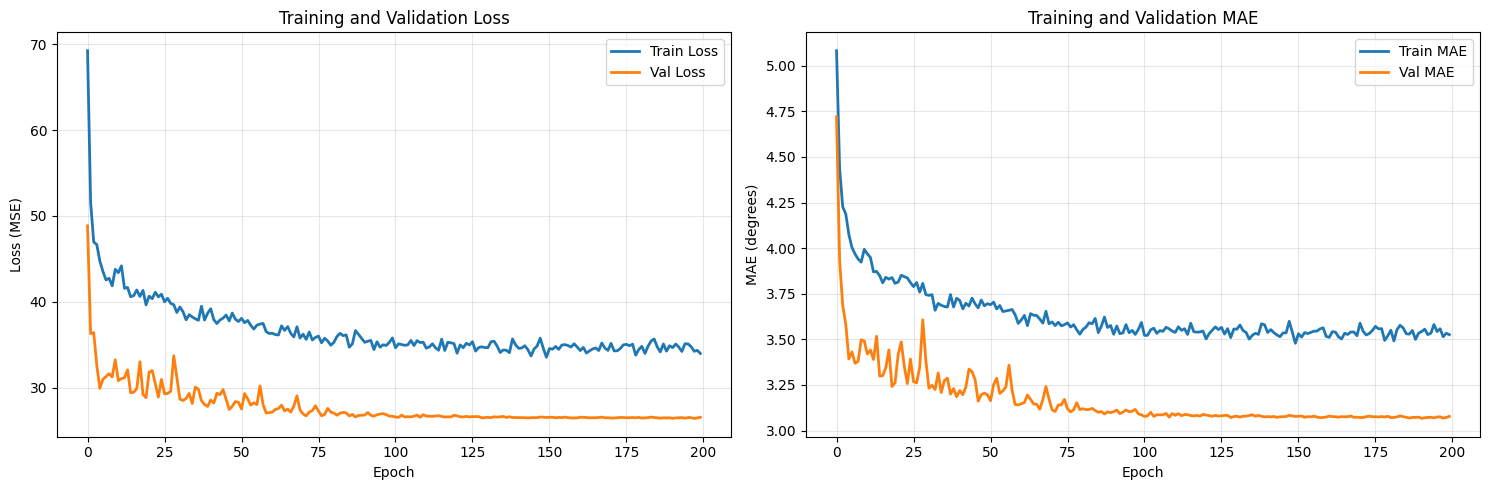


Per-Angle Error Analysis:
Roll  - MAE: 3.20°, Std: 5.36°
Pitch - MAE: 3.37°, Std: 5.24°
Yaw   - MAE: 3.14°, Std: 7.32°


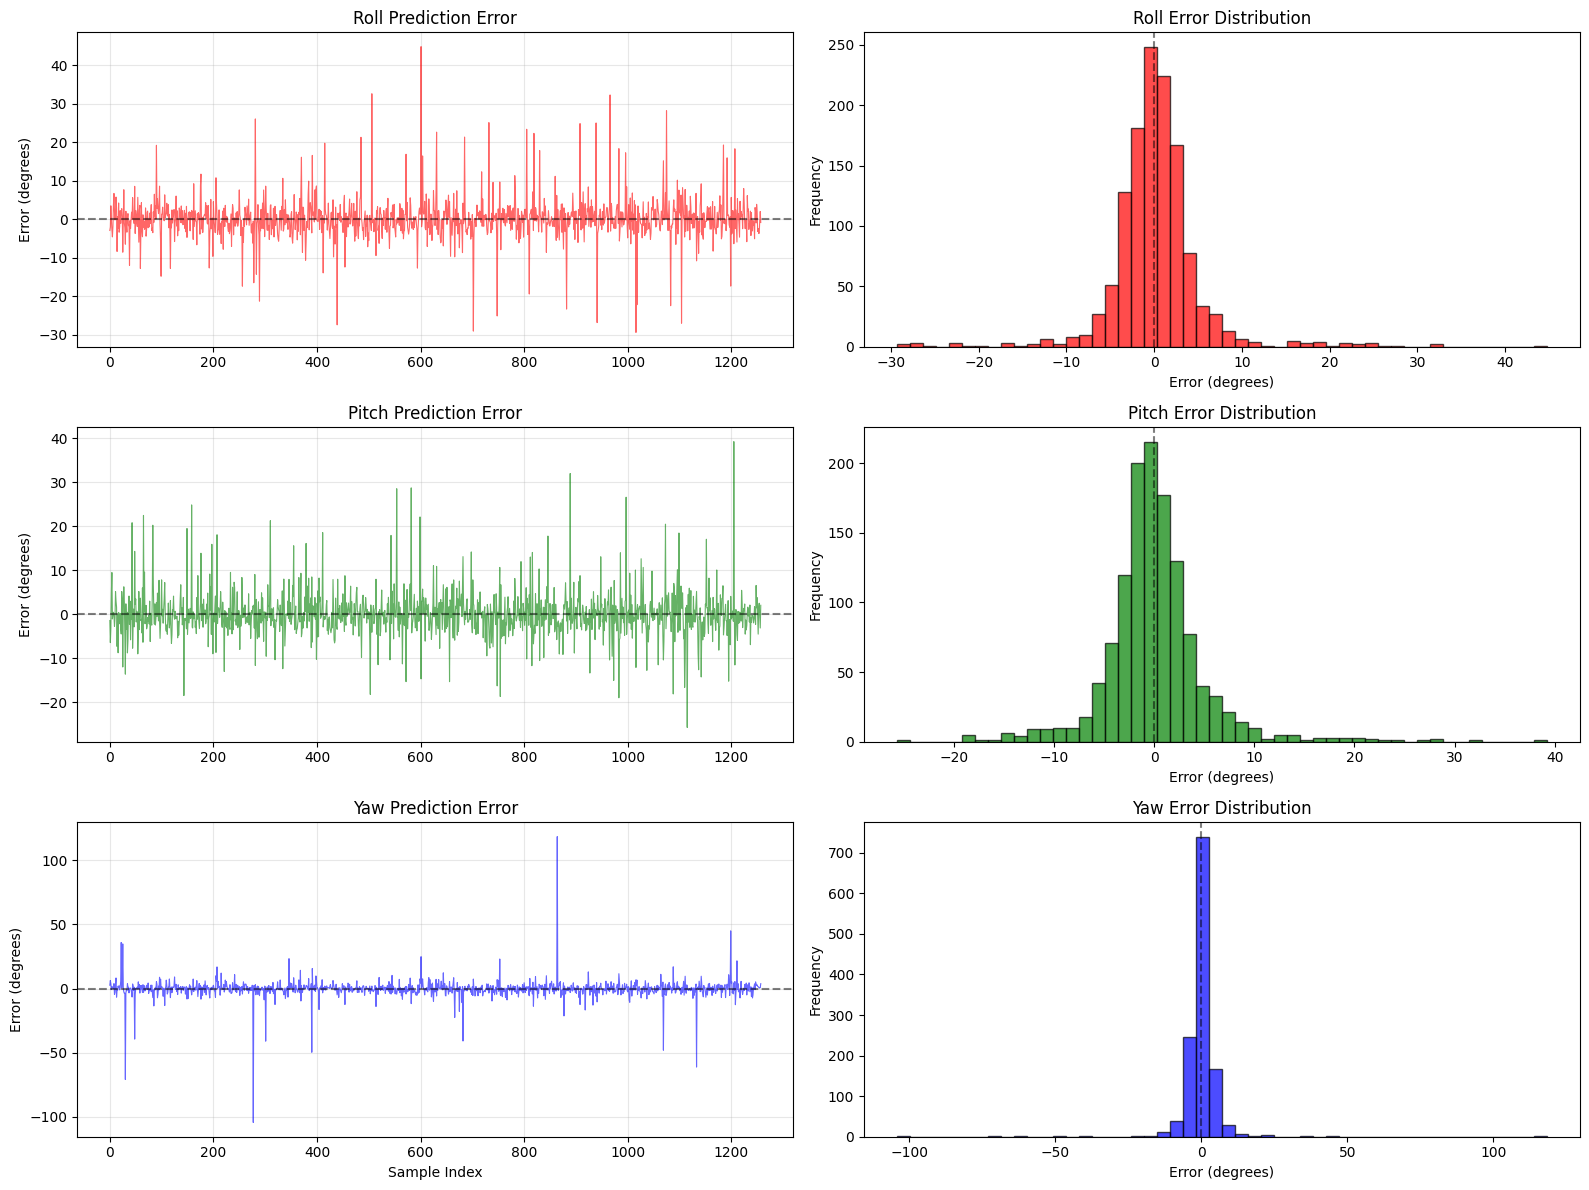

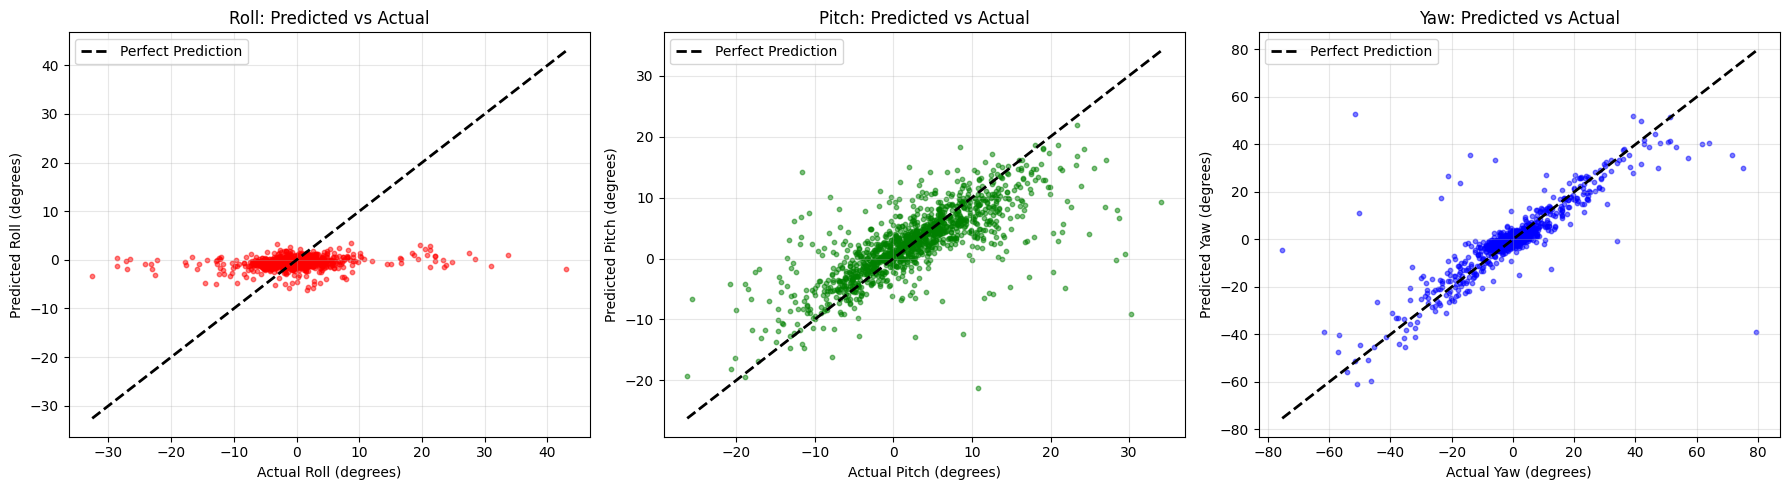

In [ ]:
# Evaluation
print("\n" + "="*50)
print("Model Evaluation:")
print("="*50)
train_loss, train_mae = model.evaluate(x_train, y_train, verbose=0)
val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

print(f"Train - Loss: {train_loss:.4f}, MAE: {train_mae:.4f}°")
print(f"Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}°")
print(f"Test  - Loss: {test_loss:.4f}, MAE: {test_mae:.4f}°")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(hist.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(hist.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(hist.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(hist.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (degrees)')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed predictions analysis
y_pred = model.predict(x_test, verbose=0)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

# Calculate per-angle metrics
print("\n" + "="*50)
print("Per-Angle Error Analysis:")
print("="*50)
print(f"Roll  - MAE: {np.abs(diff_roll).mean():.2f}°, Std: {diff_roll.std():.2f}°")
print(f"Pitch - MAE: {np.abs(diff_pitch).mean():.2f}°, Std: {diff_pitch.std():.2f}°")
print(f"Yaw   - MAE: {np.abs(diff_yaw).mean():.2f}°, Std: {diff_yaw.std():.2f}°")

# Error distribution plots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Roll
axes[0, 0].plot(diff_roll, color='red', alpha=0.6, linewidth=0.8)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Roll Prediction Error')
axes[0, 0].set_ylabel('Error (degrees)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(diff_roll, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Roll Error Distribution')
axes[0, 1].set_xlabel('Error (degrees)')
axes[0, 1].set_ylabel('Frequency')

# Pitch
axes[1, 0].plot(diff_pitch, color='green', alpha=0.6, linewidth=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Pitch Prediction Error')
axes[1, 0].set_ylabel('Error (degrees)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(diff_pitch, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Pitch Error Distribution')
axes[1, 1].set_xlabel('Error (degrees)')
axes[1, 1].set_ylabel('Frequency')

# Yaw
axes[2, 0].plot(diff_yaw, color='blue', alpha=0.6, linewidth=0.8)
axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 0].set_title('Yaw Prediction Error')
axes[2, 0].set_ylabel('Error (degrees)')
axes[2, 0].set_xlabel('Sample Index')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(diff_yaw, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Yaw Error Distribution')
axes[2, 1].set_xlabel('Error (degrees)')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter plots: predicted vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (angle, name, color) in enumerate([(0, 'Roll', 'red'),
                                              (1, 'Pitch', 'green'),
                                              (2, 'Yaw', 'blue')]):
    axes[idx].scatter(y_test[:, idx], y_pred[:, idx],
                      alpha=0.5, s=10, color=color)

    # Perfect prediction line
    min_val = min(y_test[:, idx].min(), y_pred[:, idx].min())
    max_val = max(y_test[:, idx].max(), y_pred[:, idx].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val],
                   'k--', linewidth=2, label='Perfect Prediction')

    axes[idx].set_xlabel(f'Actual {name} (degrees)')
    axes[idx].set_ylabel(f'Predicted {name} (degrees)')
    axes[idx].set_title(f'{name}: Predicted vs Actual')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Face detection and prediction functions
def detect_face_points(image):
    """Detect 68 facial landmarks using dlib"""
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    face_rects = detector(gray, 1)

    if len(face_rects) != 1:
        return []

    dlib_points = predictor(gray, face_rects[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))

    return face_points

def compute_features(face_points):
    """Compute pairwise distances between all facial landmarks"""
    assert len(face_points) == 68, "len(face_points) must be 68"

    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i] - face_points[j]))

    return np.array(features).reshape(1, -1)

def predict_head_pose(image_path, model, scaler):
    """Complete pipeline for head pose prediction"""
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    face_points = detect_face_points(im)
    if len(face_points) == 0:
        print("No face detected!")
        return None

    # Draw landmarks
    for x, y in face_points:
        cv2.circle(im, (int(x), int(y)), 2, (0, 255, 0), -1)

    # Compute features and predict
    features = compute_features(face_points)
    features = scaler.transform(features)
    prediction = model.predict(features, verbose=0)

    roll, pitch, yaw = prediction[0]

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f'Roll: {roll:.2f}° | Pitch: {pitch:.2f}° | Yaw: {yaw:.2f}°',
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\nPredicted Head Pose:")
    print(f"  Roll:  {roll:.2f}°")
    print(f"  Pitch: {pitch:.2f}°")
    print(f"  Yaw:   {yaw:.2f}°")

    return roll, pitch, yaw

In [ ]:
!pip install tensorflowjs -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


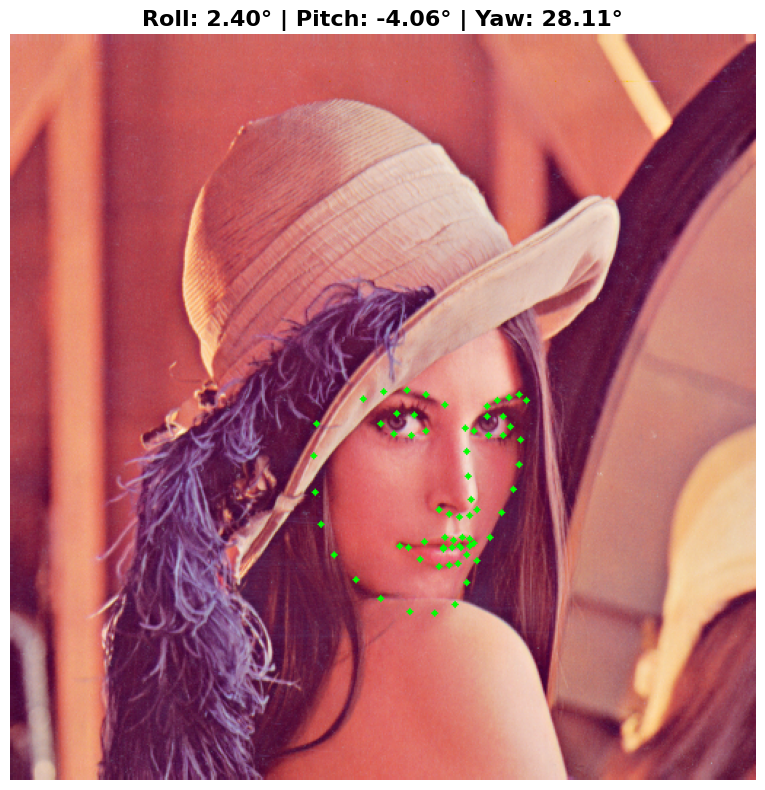


Predicted Head Pose:
  Roll:  2.40°
  Pitch: -4.06°
  Yaw:   28.11°


In [ ]:
# Test on sample image
try:
    predict_head_pose('data/lena.png', model, scaler)
except Exception as e:
    print(f"Error testing on sample image: {e}")

In [ ]:
# Export model for TensorFlow.js
print("\n" + "="*50)
print("Exporting Model for TensorFlow.js")
print("="*50)

# Load best model
best_model = keras.models.load_model("models/best_model.keras")

# Create clean model without training-specific layers
n_features = x_train.shape[1]
clean_model = Sequential([
    Input(shape=(n_features,)),
    Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_1'),
    Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_2'),
    Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_3'),
    Dense(32, activation='relu', kernel_initializer='he_normal', name='dense_4'),
    Dense(3, activation='linear', name='output')
])

# Copy weights (skip BatchNorm and Dropout layers)
source_idx = 0
for target_layer in clean_model.layers:
    # Find corresponding layer with weights in original model
    while source_idx < len(best_model.layers):
        source_layer = best_model.layers[source_idx]
        if len(source_layer.get_weights()) > 0 and source_layer.name.startswith('dense'):
            target_layer.set_weights(source_layer.get_weights())
            source_idx += 1
            break
        source_idx += 1

clean_model.compile(optimizer='adam', loss='mean_squared_error')
clean_model.save("models/model_clean.keras")

# Prepare output directory
if os.path.exists("public/model"):
    shutil.rmtree("public/model")
os.makedirs("public/model", exist_ok=True)

# Convert to TensorFlow.js
print("Converting model to TensorFlow.js...")
tfjs.converters.save_keras_model(clean_model, "public/model/")

# Verify binary file
bin_file = "public/model/group1-shard1of1.bin"
if os.path.exists(bin_file):
    file_size = os.path.getsize(bin_file)
    print(f"Binary file created: {file_size:,} bytes")
    if file_size == 0:
        print("ERROR: Binary file is empty!")
else:
    print("ERROR: Binary file not created!")

# Save scaler parameters
scaler_params = {
    'mean': scaler.mean_.tolist(),
    'scale': scaler.scale_.tolist()
}
with open('public/model/scaler_params.json', 'w') as f:
    json.dump(scaler_params, f, indent=2)

print("\Conversion complete!")
print("\nFiles created:")
for file in sorted(os.listdir("public/model")):
    filepath = os.path.join("public/model", file)
    print(f"  - {file}: {os.path.getsize(filepath):,} bytes")

print("\n" + "="*50)
print("Training Complete!")
print("="*50)


Exporting Model for TensorFlow.js


Converting model to TensorFlow.js...
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Binary file created: 2,507,020 bytes

✅ Conversion complete!

Files created:
  - group1-shard1of1.bin: 2,507,020 bytes
  - model.json: 5,021 bytes
  - scaler_params.json: 106,751 bytes

Training Complete!
